# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data = pd.read_csv('data/merged_economic_data_final.csv', parse_dates=['observation_date'])
# data.set_index('observation_date', inplace=True)
data_series = {
    col: data[['observation_date', col]].dropna()
    for col in data.columns if col != 'observation_date'
}

# Add Change Features

In [3]:
change_cols = ['M2REAL', 'CPIAUCSL', 'INDPRO', 'IC4WSA', 'WTISPLC', ]
for col in change_cols: 
    data_series[f'{col}CHNG'] = pd.DataFrame({
    'observation_date': data_series['M2REAL']['observation_date'],
    f'{col}CHNG': data_series['M2REAL']['M2REAL'].pct_change()
    }).dropna()

data_series['WTISPLCACHN'] = pd.DataFrame({
    'observation_date': data_series['WTISPLC']['observation_date'],
    'WTISPLCACHN': data_series['WTISPLC']['WTISPLC'].pct_change()
    }).dropna()

In [4]:
# Ensure 'USREC' is binary (0 or 1)
data_series['USREC']['USREC'] = data_series['USREC']['USREC'].astype(int)

# Create recession target variables for 1M, 3M, 6M, and 12M ahead
for months in [1, 3, 6, 12]:
    # If any recession occurs in the next N months, label the current row as recession
    data_series['USREC'][f'REC{months}M'] = (
        data_series['USREC']['USREC']
        .rolling(window=months, min_periods=1)
        .max()
        .shift(-months)
    )

# data_series['USREC'].dropna(inplace=True)   
from functools import reduce

# Merge all mini dataframes in data_series on 'observation_date'
full_data = reduce(
    lambda left, right: pd.merge(left, right, on='observation_date', how='outer'),
    data_series.values()
).sort_values('observation_date').reset_index(drop=True)

# Create separate datasets per forecast horizon
full_data_1M = full_data.drop(columns=['REC3M', 'REC6M', 'REC12M']).copy()
full_data_3M = full_data.drop(columns=['REC1M', 'REC6M', 'REC12M']).copy()
full_data_6M = full_data.drop(columns=['REC1M', 'REC3M', 'REC12M']).copy()
full_data_12M = full_data.drop(columns=['REC1M', 'REC3M', 'REC6M']).copy()

# Drop rows with any NaNs introduced by shifting
data_1M = full_data_1M.copy().dropna()
data_3M = full_data_3M.copy().dropna()
data_6M = full_data_6M.copy().dropna()
data_12M = full_data_12M.copy().dropna()

# Ensure targets are integers (0 or 1)
data_1M['USREC'] = data_1M['USREC'].astype(int)
data_3M['USREC'] = data_3M['USREC'].astype(int)
data_6M['USREC'] = data_6M['USREC'].astype(int)
data_12M['USREC'] = data_12M['USREC'].astype(int)

data_1M[f'REC1M'] = data_1M[f'REC1M'].astype(int)
data_3M[f'REC3M'] = data_3M[f'REC3M'].astype(int)
data_6M[f'REC6M'] = data_6M[f'REC6M'].astype(int)
data_12M[f'REC12M'] = data_12M[f'REC12M'].astype(int)

full_data_by_horizon = {
    '1M': full_data_1M,
    '3M': full_data_3M,
    '6M': full_data_6M,
    '12M': full_data_12M,
                  }

full_data.set_index('observation_date', inplace=True)
print(full_data.describe())

data = full_data.copy().dropna()
data['USREC'] = data['USREC'].astype(int)
data['REC1M'] = data['REC1M'].astype(int)
data['REC3M'] = data['REC3M'].astype(int)
data['REC6M'] = data['REC6M'].astype(int)
data['REC12M'] = data['REC12M'].astype(int)
data.describe()

             USREC        REC1M        REC3M        REC6M       REC12M  \
count  2043.000000  2042.000000  2040.000000  2037.000000  2031.000000   
mean      0.283407     0.283056     0.316667     0.367207     0.468242   
std       0.450762     0.450594     0.465290     0.482162     0.499113   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           UNRATE      AHETPI       PERMIT      AAA10Y       M2REAL  ...  \
count  926.000000  734.000000   782.000000  507.000000   793.000000  ...   
mean     5.679914   12.735068  1373.529412    1.273152  2989.628373  ...   
std      1.708815    7.512463   376.986584    0.476247  1670.539270  ...   
min      2.500000    2.500000

,USREC,REC1M,REC3M,REC6M,REC12M,UNRATE,AHETPI,PERMIT,AAA10Y,M2REAL,...,IC4WSA,WTISPLC,MTSDS133FMS,S&P500CHNG,M2REALCHNG,CPIAUCSLCHNG,INDPROCHNG,IC4WSACHNG,WTISPLCCHNG,WTISPLCACHN
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,...,4.940000e+02,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,0.072874,0.072874,0.089069,0.113360,0.161943,5.947571,16.094028,1392.825911,1.284186,3717.564170,...,3.736058e+05,45.723385,-48198.125447,0.792328,0.002517,0.002517,0.002517,0.002517,0.002517,0.006237
std,0.260194,0.260194,0.285132,0.317354,0.368772,1.748968,5.717414,385.067695,0.477348,1564.482641,...,2.574306e+05,28.861786,104729.175254,3.550048,0.006422,0.006422,0.006422,0.006422,0.006422,0.094389
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.400000,8.060000,513.000000,-0.125909,2001.400000,...,1.975000e+05,11.280000,-864074.068492,-20.400000,-0.014808,-0.014808,-0.014808,-0.014808,-0.014808,-0.433413
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.700000,10.995000,1141.000000,0.901667,2444.850000,...,3.050625e+05,20.343250,-81946.708814,-0.780000,-0.000703,-0.000703,-0.000703,-0.000703,-0.000703,-0.046627
50%,0.000000,0.000000,0.000000,0.000000,0.000000,5.600000,15.410000,1429.500000,1.230089,3276.300000,...,3.413750e+05,32.030000,-32186.000000,1.070000,0.002157,0.002157,0.002157,0.002157,0.002157,0.010131
75%,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,20.295000,1665.750000,1.643327,4695.250000,...,3.971250e+05,67.835000,2869.500000,2.950000,0.004595,0.004595,0.004595,0.004595,0.004595,0.056298
max,1.000000,1.000000,1.000000,1.000000,1.000000,14.800000,29.670000,2263.000000,2.675909,7659.400000,...,3.828000e+06,133.930000,308215.060527,12.020000,0.072220,0.072220,0.072220,0.072220,0.072220,0.725680


Created 2 splits based on recession periods:
  Split 1: 1983-01-01 to 2005-07-01, 271 samples, contains recession #1
  Split 2: 2005-07-01 to 2024-08-01, 224 samples, contains recession #2


IndexError: list index out of range

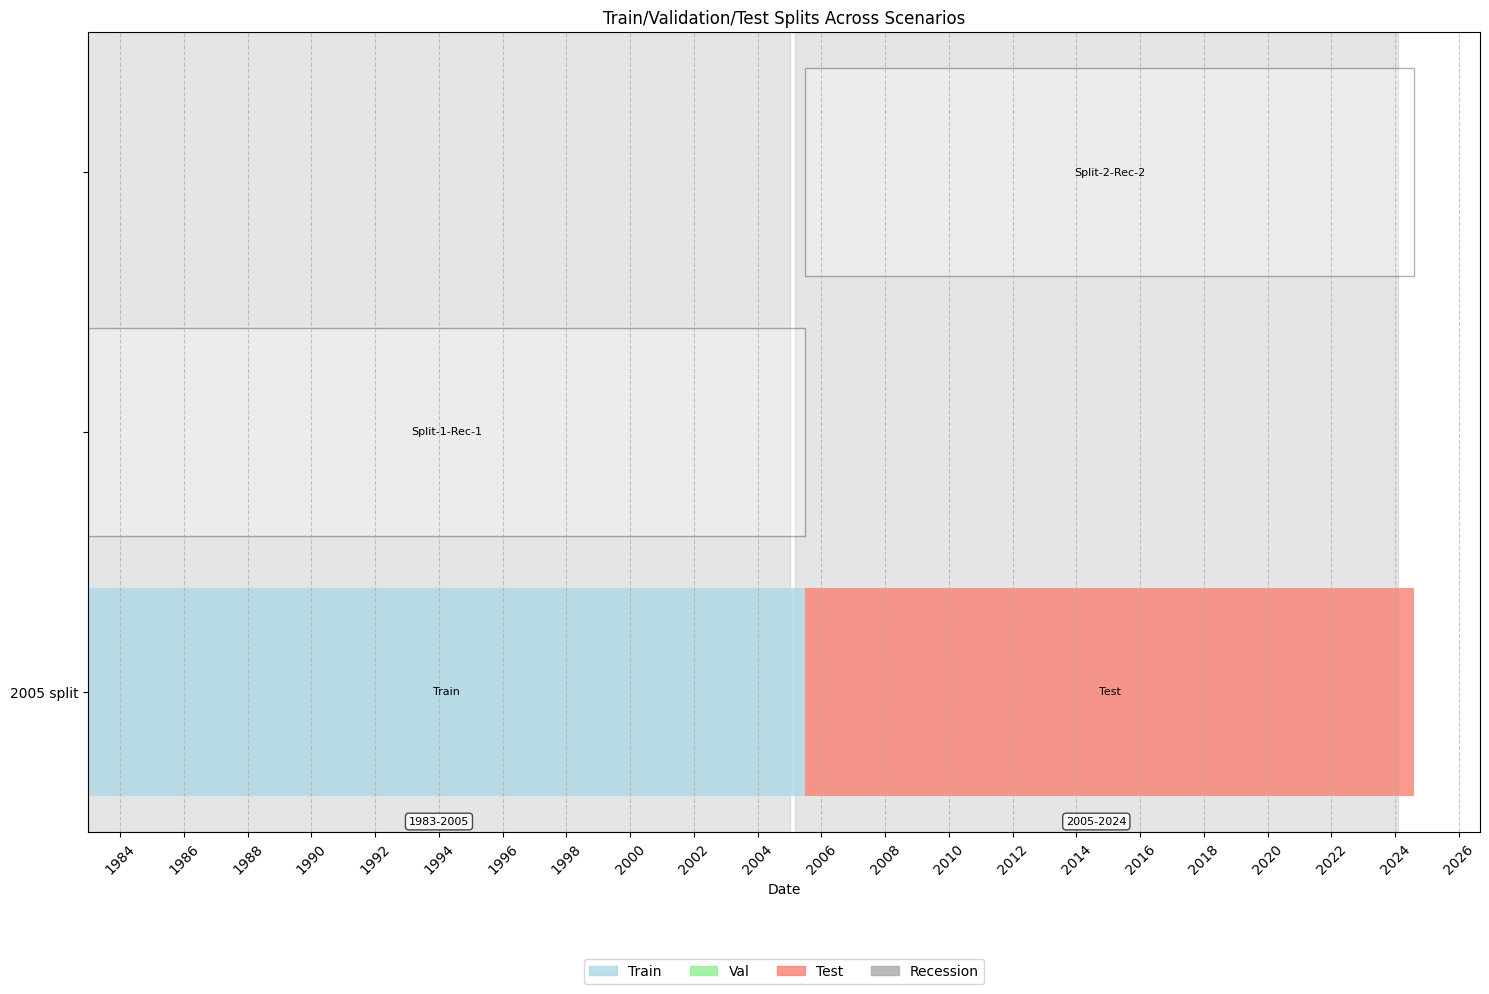

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define US recession periods since 1983
RECESSION_PERIODS = [
    ('1983-01-01', '2005-01-01'),  # 1990-1991 recession
    ('2005-03-01', '2024-02-01'),  # 2001 recession
]

# Convert to datetime
RECESSION_PERIODS = [(pd.Timestamp(start), pd.Timestamp(end)) 
                     for start, end in RECESSION_PERIODS]

def create_recession_based_splits(data, data_start='1983-01-01'):
    """
    Create fixed data splits based on complete recession periods.
    
    Each split contains data from the end of the previous recession (or data_start)
    to 6 months after the end of a recession.
    
    Parameters:
    -----------
    data : DataFrame with datetime index
    data_start : str, start date for the dataset
    
    Returns:
    --------
    List of split dictionaries
    """
    start_date = pd.Timestamp(data_start)
    actual_start = max(start_date, data.index.min())
    
    # Create split boundaries (start of split to 6 months after end of recession)
    split_boundaries = []
    prev_end = actual_start
    
    for i, (rec_start, rec_end) in enumerate(RECESSION_PERIODS):
        # End of this split is 6 months after recession ends
        split_end = rec_end + pd.DateOffset(months=6)
        
        # Only include splits that are within our data range
        if split_end >= actual_start and prev_end <= data.index.max():
            split_boundaries.append((prev_end, split_end))
        
        # Start of next split is the end of this split
        prev_end = split_end
    
    # Modify: Instead of having the last split go to the end of the data,
    # we'll only include data up to the last recession + 6 months
    # This ensures all splits contain recession periods
    last_recession_end = RECESSION_PERIODS[-1][1] + pd.DateOffset(months=6)
    
    # Add final split from last recession+6mo to end of recession period
    if prev_end < last_recession_end:
        split_boundaries.append((prev_end, last_recession_end))
    
    # Create the actual splits
    splits = []
    for i, (start, end) in enumerate(split_boundaries):
        split_mask = pd.Series((data.index >= start) & (data.index <= end), index=data.index)
        
        # Skip if empty
        if not split_mask.any():
            continue
            
        # Find which recession is in this split
        contained_recessions = []
        for j, (rec_start, rec_end) in enumerate(RECESSION_PERIODS):
            rec_mask = (data.index >= rec_start) & (data.index <= rec_end)
            if (split_mask & rec_mask).any():
                contained_recessions.append(j)
        
        rec_label = "" if not contained_recessions else f"Rec-{contained_recessions[0]+1}"
        
        splits.append({
            'name': f"Split-{i+1}-{rec_label}",
            'mask': split_mask,
            'period': (start, end),
            'contains_recession': len(contained_recessions) > 0,
            'recession_index': contained_recessions[0] if contained_recessions else None
        })
    
    print(f"Created {len(splits)} splits based on recession periods:")
    for i, split in enumerate(splits):
        start, end = split['period']
        samples = split['mask'].sum()
        rec_info = f"contains recession #{split['recession_index']+1}" if split['contains_recession'] else "no recession"
        print(f"  Split {i+1}: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}, {samples} samples, {rec_info}")
    
    return splits

def assign_train_val_test_roles(splits, scenario):
    """
    Assign train/validation/test roles to the fixed splits.
    
    Parameters:
    -----------
    splits : List of split dictionaries
    scenario : Dict with keys 'train', 'val', 'test' and values as lists of split indices
    
    Returns:
    --------
    Dictionary with train/val/test masks
    """
    if not splits:
        return None
    
    # Get a sample mask to determine index
    sample_mask = splits[0]['mask']
    index = sample_mask.index
    
    # Initialize empty masks
    train_mask = pd.Series(False, index=index)
    val_mask = pd.Series(False, index=index)
    test_mask = pd.Series(False, index=index)
    
    # Assign roles based on scenario
    for train_idx in scenario['train']:
        if 0 <= train_idx < len(splits):
            train_mask = train_mask | splits[train_idx]['mask']
    
    # Check if validation indices are provided
    if 'val' in scenario and scenario['val']:
        for val_idx in scenario['val']:
            if 0 <= val_idx < len(splits):
                val_mask = val_mask | splits[val_idx]['mask']
    else:
        # If no validation set is specified, create an empty validation mask
        val_mask = pd.Series(False, index=index)
    
    for test_idx in scenario['test']:
        if 0 <= test_idx < len(splits):
            test_mask = test_mask | splits[test_idx]['mask']
    
    return {
        'train_mask': train_mask,
        'val_mask': val_mask,
        'test_mask': test_mask
    }

def visualize_splits_combined(data, splits, scenarios):
    """
    Create a visualization showing all scenarios on one plot with different colors.
    
    Parameters:
    -----------
    data : DataFrame with datetime index
    splits : List of split dictionaries
    scenarios : List of scenario dictionaries
    
    Returns:
    --------
    Figure and axes objects
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Set a consistent color scheme for roles
    role_colors = {
        'train': 'lightblue',
        'val': 'lightgreen',
        'test': 'salmon',
        'unused': 'lightgray',
        'recession': 'darkgray'
    }
    
    # Plot recession periods as background spans
    for i, (rec_start, rec_end) in enumerate(RECESSION_PERIODS):
        ax.axvspan(rec_start, rec_end, alpha=0.3, color=role_colors['recession'], 
                   label='Recession' if i == 0 else "")
        
        # Add recession label
        mid_rec = rec_start + (rec_end - rec_start) / 2
        y_pos = -0.5
        ax.text(mid_rec, y_pos, f'{rec_start.year}-{rec_end.year}', 
                ha='center', va='center', color='black', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Reserve top space for split labels
    y_pos_start = len(scenarios)
    
    # Plot each split
    for i, split in enumerate(splits):
        start, end = split['period']
        width_days = (end - start).days
        
        # Add split labels at the top
        ax.barh(y_pos_start + i, width=width_days, left=start, height=0.8, 
                color='white', alpha=0.3, edgecolor='black')
        
        if width_days > 200:  # Only add text if wide enough
            mid_split = start + (end - start) / 2
            ax.text(mid_split, y_pos_start + i, split['name'],
                    ha='center', va='center', color='black', fontsize=8)
    
    # Plot each scenario
    for i, scenario in enumerate(scenarios):
        scenario_name = scenario['name']
        masks = assign_train_val_test_roles(splits, scenario)
        
        # Skip if no valid masks
        if not masks:
            continue
        
        # Plot training period
        for j, split_idx in enumerate(scenario['train']):
            if 0 <= split_idx < len(splits):
                split = splits[split_idx]
                start, end = split['period']
                ax.barh(i, width=(end - start).days, left=start, height=0.8, 
                        color=role_colors['train'], alpha=0.8)
                
                # Add text if wide enough
                width_days = (end - start).days
                if width_days > 200:  # Only add text if wide enough
                    mid_train = start + (end - start) / 2
                    ax.text(mid_train, i, 'Train', 
                            ha='center', va='center', color='black', fontsize=8)
        
        # Plot validation period
        for j, split_idx in enumerate(scenario['val']):
            if 0 <= split_idx < len(splits):
                split = splits[split_idx]
                start, end = split['period']
                ax.barh(i, width=(end - start).days, left=start, height=0.8, 
                        color=role_colors['val'], alpha=0.8)
                
                # Add text if wide enough
                width_days = (end - start).days
                if width_days > 200:  # Only add text if wide enough
                    mid_val = start + (end - start) / 2
                    ax.text(mid_val, i, 'Val', 
                            ha='center', va='center', color='black', fontsize=8)
        
        # Plot test period
        for j, split_idx in enumerate(scenario['test']):
            if 0 <= split_idx < len(splits):
                split = splits[split_idx]
                start, end = split['period']
                ax.barh(i, width=(end - start).days, left=start, height=0.8, 
                        color=role_colors['test'], alpha=0.8)
                
                # Add text if wide enough
                width_days = (end - start).days
                if width_days > 200:  # Only add text if wide enough
                    mid_test = start + (end - start) / 2
                    ax.text(mid_test, i, 'Test', 
                            ha='center', va='center', color='black', fontsize=8)
    
    # Set the y-ticks and labels
    ax.set_yticks(list(range(len(scenarios))) + [y_pos_start + i for i in range(len(splits))])
    ax.set_yticklabels([s['name'] for s in scenarios] + ["" for _ in range(len(splits))])
    
    # Format the x-axis as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))  # Every 2 years
    plt.xticks(rotation=45)
    
    # Add grid, legend, and labels
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.set_xlabel('Date')
    ax.set_title('Train/Validation/Test Splits Across Scenarios')
    
    # Add a legend
    legend_handles = []
    legend_labels = []
    for role, color in role_colors.items():
        if role != 'unused':  # Skip unused in the legend
            handle = plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.8)
            legend_handles.append(handle)
            legend_labels.append(role.capitalize())
    
    ax.legend(legend_handles, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, -0.15), ncol=len(legend_handles))
    
    plt.tight_layout()
    return fig, ax

def find_optimal_threshold(y_true, y_proba, metric='f1', beta=1.0):
    """
    Find the optimal probability threshold for classification.
    
    Parameters:
    -----------
    y_true : True labels
    y_proba : Predicted probabilities
    metric : Metric to optimize ('f1', 'precision', 'recall', 'accuracy', or 'balanced')
    beta : Beta value for F-beta score (higher beta gives more weight to recall)
    
    Returns:
    --------
    Optimal threshold and score
    """
    # Create a range of thresholds to test
    thresholds = np.arange(0.1, 0.95, 0.05)
    
    # Store scores for each threshold
    scores = []
    
    for threshold in thresholds:
        # Convert probabilities to predictions using this threshold
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calculate the chosen metric
        if metric == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        elif metric == 'accuracy':
            score = accuracy_score(y_true, y_pred)
        elif metric == 'fbeta':
            score = f1_score(y_true, y_pred, beta=beta, zero_division=0)
        elif metric == 'balanced':
            # Custom balanced metric (e.g., average of precision and recall)
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec = recall_score(y_true, y_pred, zero_division=0)
            score = (prec + rec) / 2
        
        scores.append(score)
    
    # Find threshold with the best score
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_score = scores[best_idx]
    
    return best_threshold, best_score

def plot_threshold_performance(y_true, y_proba, model_name='Model'):
    """
    Plot performance metrics across different classification thresholds.
    
    Parameters:
    -----------
    y_true : True labels
    y_proba : Predicted probabilities
    model_name : Name of the model for the title
    
    Returns:
    --------
    Figure object
    """
    thresholds = np.arange(0.1, 0.95, 0.01)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision_scores.append(precision_score(y_true, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_true, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(thresholds, precision_scores, 'b-', label='Precision')
    ax.plot(thresholds, recall_scores, 'g-', label='Recall')
    ax.plot(thresholds, f1_scores, 'r-', label='F1 Score')
    
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_title(f'Performance Metrics at Different Classification Thresholds - {model_name}')
    ax.grid(True)
    
    # Mark the default threshold
    ax.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
    
    # Find and mark optimal F1 threshold
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    ax.axvline(x=optimal_threshold, color='red', linestyle='--', 
              label=f'Optimal F1 Threshold ({optimal_threshold:.2f})')
    
    ax.legend()
    plt.tight_layout()
    return fig


# Base Model class
class RecessionModel:
    """Base class for all recession prediction models."""
    
    def __init__(self, name, tune_hyperparams=True, tune_threshold=True, fixed_threshold=0.5):
        """
        Initialize a recession prediction model.
        
        Parameters:
        -----------
        name : Name of the model
        tune_hyperparams : Whether to tune hyperparameters using validation data
        tune_threshold : Whether to tune the classification threshold
        fixed_threshold : Fixed classification threshold to use if tune_threshold is False
        """
        self.name = name
        self.tune_hyperparams = tune_hyperparams
        self.tune_threshold = tune_threshold
        self.model = None
        self.feature_transformer = None
        self.scaler = None
        self.best_params = {}
        self.optimal_threshold = fixed_threshold
        self.train_metrics = {}
        self.val_metrics = {}
        self.test_metrics = {}
        
    def preprocess_data(self, X_train, X_val=None, X_test=None):
        """
        Apply preprocessing transformations to the data.
        
        Parameters:
        -----------
        X_train, X_val, X_test : Feature matrices
        
        Returns:
        --------
        Transformed features
        """
        # Apply Box-Cox/Yeo-Johnson transformation
        self.feature_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
        X_train_transformed = self.feature_transformer.fit_transform(X_train)
        
        # Apply standard scaling
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train_transformed)
        
        # Process validation and test sets if provided
        X_val_scaled, X_test_scaled = None, None
        
        if X_val is not None:
            X_val_transformed = self.feature_transformer.transform(X_val)
            X_val_scaled = self.scaler.transform(X_val_transformed)
        
        if X_test is not None:
            X_test_transformed = self.feature_transformer.transform(X_test)
            X_test_scaled = self.scaler.transform(X_test_transformed)
        
        return X_train_scaled, X_val_scaled, X_test_scaled
    
    def tune_hyperparameters(self, X_train, y_train, X_val, y_val, param_grid):
        """
        Tune hyperparameters using validation data.
        
        Parameters:
        -----------
        X_train, y_train : Training data
        X_val, y_val : Validation data
        param_grid : Hyperparameter grid to search
        
        Returns:
        --------
        Best parameters (not the trained model)
        """
        print(f"\nTuning hyperparameters for {self.name}...")
        
        # Create base model
        base_model = self._create_base_model()
        
        # Set up grid search with k-fold cross-validation
        grid_search = GridSearchCV(
            base_model,
            param_grid,
            cv=5,  # 5-fold cross-validation
            scoring='f1',  # Primary metric to optimize
            n_jobs=-1,  # Use all CPU cores
            verbose=1
        )
        
        # Fit grid search on training data only
        grid_search.fit(X_train, y_train)
        
        # Validate the best model on validation data
        best_model = grid_search.best_estimator_
        val_pred = best_model.predict(X_val)
        val_score = f1_score(y_val, val_pred, zero_division=0)
        
        # Print results
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
        print(f"Validation score: {val_score:.3f}")
        
        # Return best parameters (not the model)
        return grid_search.best_params_
    
    def _create_base_model(self):
        """Create a base model instance (to be implemented by subclasses)."""
        raise NotImplementedError("Subclasses must implement this method")
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Fit the model to training data with proper training procedure:
        1. Train initial model on training data
        2. Use validation data to find optimal hyperparameters (if available)
        3. Find optimal threshold (if threshold tuning is enabled and validation data available) 
        4. Retrain final model on combined train+validation data with optimal hyperparameters (if validation available)
        5. Evaluate on test data
        
        Parameters:
        -----------
        X_train, y_train : Training data
        X_val, y_val : Validation data (optional)
        
        Returns:
        --------
        self (for method chaining)
        """
        # Check if validation data is provided
        has_validation = X_val is not None and y_val is not None and len(X_val) > 0 and len(y_val) > 0
        
        # Preprocess data
        X_train_scaled, X_val_scaled, _ = self.preprocess_data(X_train, X_val if has_validation else None)
        
        # If tuning hyperparameters and validation data is provided
        if self.tune_hyperparams and has_validation:
            # Step 1: Find optimal hyperparameters using training data and validation data
            param_grid = self._get_param_grid()
            self.best_params = self.tune_hyperparameters(
                X_train_scaled, y_train, X_val_scaled, y_val, param_grid
            )
            
            # First create a model with best hyperparameters and train on training data only
            validation_model = self._create_base_model().set_params(**self.best_params)
            validation_model.fit(X_train_scaled, y_train)
            
            # Get validation probabilities
            if hasattr(validation_model, "predict_proba"):
                val_proba = validation_model.predict_proba(X_val_scaled)[:, 1]
            else:
                val_proba = validation_model.decision_function(X_val_scaled)
                val_proba = (val_proba - val_proba.min()) / (val_proba.max() - val_proba.min())
            
            # Find optimal threshold if threshold tuning is enabled
            if self.tune_threshold:
                self.optimal_threshold, best_score = find_optimal_threshold(y_val, val_proba, metric='f1')
                print(f"Optimal threshold: {self.optimal_threshold:.3f} (F1: {best_score:.3f})")
            else:
                print(f"Using fixed threshold: {self.optimal_threshold}")
            
            # Compute validation metrics with threshold for reference
            val_pred = (val_proba >= self.optimal_threshold).astype(int)
            self.val_metrics = self._compute_metrics(y_val, val_pred, val_proba)
            
            # Step 2: Create final model with best parameters and train on combined data
            print("Training final model on combined training and validation data...")
            self.model = self._create_base_model().set_params(**self.best_params)
            
            # Combine training and validation data for final model
            X_combined = np.vstack([X_train_scaled, X_val_scaled])
            y_combined = np.hstack([y_train, y_val])
            
            # Fit the model on combined data
            self.model.fit(X_combined, y_combined)
            
        else:
            # If no validation data or not tuning hyperparameters
            if not has_validation:
                print("No validation data provided. Training on training data only.")
                if self.tune_hyperparams:
                    print("Warning: Hyperparameter tuning disabled due to missing validation data.")
                if self.tune_threshold:
                    print("Warning: Threshold tuning disabled due to missing validation data.")
            
            # Create and fit model with default or provided parameters
            if self.tune_hyperparams and not has_validation:
                # Use default parameters if we can't tune
                self.model = self._create_base_model()
            elif not self.tune_hyperparams and self.best_params:
                # Use provided best parameters if available
                self.model = self._create_base_model().set_params(**self.best_params)
            else:
                # Default case
                self.model = self._create_base_model()
                
            # Train on training data only
            self.model.fit(X_train_scaled, y_train)
        
        # Compute training metrics (on original training data only, for fair comparison)
        if hasattr(self.model, "predict_proba"):
            train_proba = self.model.predict_proba(X_train_scaled)[:, 1]
        else:
            train_proba = self.model.decision_function(X_train_scaled)
            train_proba = (train_proba - train_proba.min()) / (train_proba.max() - train_proba.min())
        
        train_pred = (train_proba >= self.optimal_threshold).astype(int)
        self.train_metrics = self._compute_metrics(y_train, train_pred, train_proba)
        
        return self
    
    def predict(self, X, use_optimal_threshold=True):
        """
        Make binary predictions on new data.
        
        Parameters:
        -----------
        X : Features
        use_optimal_threshold : Whether to use the optimal threshold found during training
        
        Returns:
        --------
        Binary predictions and probabilities
        """
        # Transform features
        X_transformed = self.feature_transformer.transform(X)
        X_scaled = self.scaler.transform(X_transformed)
        
        # Get probability predictions
        if hasattr(self.model, "predict_proba"):
            proba = self.model.predict_proba(X_scaled)[:, 1]
        else:
            proba = self.model.decision_function(X_scaled)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        
        # Apply threshold
        threshold = self.optimal_threshold if use_optimal_threshold else 0.5
        return (proba >= threshold).astype(int), proba
    
    def evaluate(self, X_test, y_test, use_optimal_threshold=True):
        """
        Evaluate model on test data.
        
        Parameters:
        -----------
        X_test, y_test : Test data
        use_optimal_threshold : Whether to use the optimal threshold found during training
        
        Returns:
        --------
        Test metrics
        """
        # Get predictions
        y_pred, y_proba = self.predict(X_test, use_optimal_threshold)
        
        # Compute metrics
        self.test_metrics = self._compute_metrics(y_test, y_pred, y_proba)
        
        return self.test_metrics
    
    def _compute_metrics(self, y_true, y_pred, y_proba):
        """Compute classification metrics."""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
        }
        
        # Only compute AUC if there are both positive and negative examples
        if len(np.unique(y_true)) > 1:
            metrics['auc'] = roc_auc_score(y_true, y_proba)
        else:
            metrics['auc'] = np.nan
        
        return metrics
    
    def visualize_results(self, X_test, y_test, dates, title="Test Results"):
        """
        Visualize model predictions vs actual values.
        
        Parameters:
        -----------
        X_test : Test features
        y_test : Test labels
        dates : Dates for test data
        title : Plot title
        
        Returns:
        --------
        Figure object
        """
        # Get predictions
        y_pred, y_proba = self.predict(X_test, use_optimal_threshold=True)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot recession periods as background
        for i, (rec_start, rec_end) in enumerate(RECESSION_PERIODS):
            ax.axvspan(rec_start, rec_end, alpha=0.3, color='lightgray',
                     label='Actual Recession Period' if i == 0 else "")
        
        # Plot actual recession indicator
        ax.plot(dates, y_test, 'k-', label='Actual Recession', linewidth=2)
        
        # Plot model predictions (threshold-based)
        ax.plot(dates, y_pred, 'b-', label=f'Predicted Recession (Threshold={self.optimal_threshold:.2f})', linewidth=1.5)
        
        # Plot model probabilities
        ax.plot(dates, y_proba, 'r--', label=f'Probability Estimate', alpha=0.6)
        
        # Add optimal threshold line
        ax.axhline(y=self.optimal_threshold, color='r', linestyle='--', alpha=0.5,
                 label=f'Optimal Threshold={self.optimal_threshold:.2f}')
        
        # Format plot
        ax.set_title(f"{self.name} - {title}")
        ax.set_xlabel('Date')
        ax.set_ylabel('Recession Status / Probability')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper right')
        
        # Format x-axis as dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        return fig
    
    def print_metrics_summary(self):
        """Print a summary of model metrics."""
        print(f"\n{'-'*80}")
        print(f"Metrics Summary for {self.name}")
        print(f"{'-'*80}")
        
        # Build a DataFrame for better visualization
        metrics_df = pd.DataFrame({
            'Training': {k: f"{v:.3f}" for k, v in self.train_metrics.items()},
            'Validation': {k: f"{v:.3f}" for k, v in self.val_metrics.items()} if self.val_metrics else {},
            'Test': {k: f"{v:.3f}" for k, v in self.test_metrics.items()} if self.test_metrics else {}
        }).T
        
        print(metrics_df)
        print(f"\nOptimal threshold: {self.optimal_threshold:.3f}")
        if self.best_params:
            print(f"\nBest hyperparameters:")
            for param, value in self.best_params.items():
                print(f"  {param}: {value}")
        
        return metrics_df
    
    def _get_param_grid(self):
        """Get parameter grid for hyperparameter tuning (to be implemented by subclasses)."""
        raise NotImplementedError("Subclasses must implement this method")

# Logistic Regression model
class LogisticRegressionModel(RecessionModel):
    """Logistic Regression model for recession prediction."""
    
    def __init__(self, tune_hyperparams=True, tune_threshold=True, fixed_threshold=0.5):
        super().__init__("Logistic Regression", tune_hyperparams, tune_threshold, fixed_threshold)
    
    def _create_base_model(self):
        return LogisticRegression(max_iter=2000, random_state=42)
    
    def _get_param_grid(self):
        return {
            'C': [0.01, 0.1, 1.0, 10.0],
            'class_weight': ['balanced', None],
            'solver': ['liblinear', 'saga'],
            'penalty': ['l1', 'l2']
        }

# Gaussian Naive Bayes model
class GaussianNBModel(RecessionModel):
    """Gaussian Naive Bayes model for recession prediction."""
    
    def __init__(self, tune_hyperparams=False, tune_threshold=True, fixed_threshold=0.5):  # GNB has few hyperparameters to tune
        super().__init__("Gaussian Naive Bayes", tune_hyperparams, tune_threshold, fixed_threshold)
    
    def _create_base_model(self):
        return GaussianNB()
    
    def _get_param_grid(self):
        return {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }

# Random Forest model
class RandomForestModel(RecessionModel):
    """Random Forest model for recession prediction."""
    
    def __init__(self, tune_hyperparams=True, tune_threshold=True, fixed_threshold=0.5):
        super().__init__("Random Forest", tune_hyperparams, tune_threshold, fixed_threshold)
    
    def _create_base_model(self):
        return RandomForestClassifier(random_state=42)
    
    def _get_param_grid(self):
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }

# XGBoost model
class XGBoostModel(RecessionModel):
    """XGBoost model for recession prediction."""
    
    def __init__(self, tune_hyperparams=True, tune_threshold=True, fixed_threshold=0.5):
        super().__init__("XGBoost", tune_hyperparams, tune_threshold, fixed_threshold)
    
    def _create_base_model(self):
        return XGBClassifier(random_state=42)
    
    def _get_param_grid(self):
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'scale_pos_weight': [1, 5, 10]
        }

# Ensemble model
class EnsembleModel(RecessionModel):
    """Ensemble model combining multiple recession prediction models."""
    
    def __init__(self, base_models=None, tune_threshold=True, fixed_threshold=0.5):
        super().__init__("Ensemble", tune_hyperparams=False, tune_threshold=tune_threshold, fixed_threshold=fixed_threshold)
        self.base_models = base_models if base_models else []
        
    def _create_base_model(self):
        # Ensemble doesn't have a specific base model
        return None
    
    def _get_param_grid(self):
        # Ensemble doesn't need hyperparameter tuning
        return {}
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Fit all base models.
        
        Parameters:
        -----------
        X_train, y_train : Training data
        X_val, y_val : Validation data (optional)
        
        Returns:
        --------
        self (for method chaining)
        """
        # Check if validation data is provided
        has_validation = X_val is not None and y_val is not None and len(X_val) > 0 and len(y_val) > 0
        
        # Fit all base models
        for model in self.base_models:
            model.fit(X_train, y_train, X_val, y_val)
        
        # If validation data is provided, find optimal threshold (if enabled)
        if has_validation:
            # Get probability predictions from all models
            val_probas = []
            for model in self.base_models:
                _, proba = model.predict(X_val, use_optimal_threshold=False)
                val_probas.append(proba)
            
            # Average probabilities
            val_proba_ensemble = np.mean(val_probas, axis=0)
            
            # Find optimal threshold for ensemble if threshold tuning is enabled
            if self.tune_threshold:
                self.optimal_threshold, best_score = find_optimal_threshold(y_val, val_proba_ensemble, metric='f1')
                print(f"Optimal threshold for ensemble: {self.optimal_threshold:.3f} (F1: {best_score:.3f})")
            else:
                print(f"Using fixed threshold for ensemble: {self.optimal_threshold}")
            
            # Compute validation metrics with threshold
            val_pred_ensemble = (val_proba_ensemble >= self.optimal_threshold).astype(int)
            self.val_metrics = self._compute_metrics(y_val, val_pred_ensemble, val_proba_ensemble)
        else:
            print("No validation data provided for ensemble. Using fixed threshold.")
        
        return self
    
    def predict(self, X, use_optimal_threshold=True):
        """
        Make predictions by averaging base model predictions.
        
        Parameters:
        -----------
        X : Features
        use_optimal_threshold : Whether to use the optimal threshold found during training
        
        Returns:
        --------
        Binary predictions and probabilities
        """
        # Get predictions from all base models
        probas = []
        for model in self.base_models:
            _, proba = model.predict(X, use_optimal_threshold=False)
            probas.append(proba)
        
        # Average probabilities
        proba_ensemble = np.mean(probas, axis=0)
        
        # Apply threshold
        threshold = self.optimal_threshold if use_optimal_threshold else 0.5
        return (proba_ensemble >= threshold).astype(int), proba_ensemble
    
    def evaluate(self, X_test, y_test, use_optimal_threshold=True):
        """
        Evaluate ensemble on test data.
        
        Parameters:
        -----------
        X_test, y_test : Test data
        use_optimal_threshold : Whether to use the optimal threshold found during training
        
        Returns:
        --------
        Test metrics
        """
        # Get predictions
        y_pred, y_proba = self.predict(X_test, use_optimal_threshold)
        
        # Compute metrics
        self.test_metrics = self._compute_metrics(y_test, y_pred, y_proba)
        
        # Also evaluate each base model for comparison
        for model in self.base_models:
            model.evaluate(X_test, y_test, use_optimal_threshold)
        
        return self.test_metrics
    
    def print_metrics_summary(self):
        """
        Print a summary of ensemble model metrics compared to base models.
        """
        # First print ensemble metrics
        metrics_df = super().print_metrics_summary()
        
        # Now create a table comparing all models on test data
        test_metrics = {}
        
        # Add ensemble metrics
        test_metrics['Ensemble'] = self.test_metrics
        
        # Add base model metrics
        for model in self.base_models:
            test_metrics[model.name] = model.test_metrics
        
        # Convert to DataFrame for nice display
        comparison_df = pd.DataFrame(test_metrics).T
        
        # Round values
        comparison_df = comparison_df.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
        
        print("\nTest Metrics Comparison:")
        print(comparison_df)
        
        return metrics_df, comparison_df

# RecessionPredictionPipeline class to orchestrate the whole process
class RecessionPredictionPipeline:
    """Pipeline for recession prediction across multiple horizons and scenarios."""
    
    def __init__(self, data, feature_sets, splits=None, scenarios=None, tune_hyperparams=True, 
                 tune_threshold=True, fixed_threshold=0.5):
        """
        Initialize the recession prediction pipeline.
        
        Parameters:
        -----------
        data : DataFrame with datetime index containing economic indicators and recession labels
        feature_sets : Dictionary of feature sets by horizon
        splits : List of split dictionaries
        scenarios : List of scenario dictionaries
        tune_hyperparams : Whether to tune hyperparameters for models
        tune_threshold : Whether to tune classification thresholds
        fixed_threshold : Fixed threshold to use if tune_threshold is False
        """
        self.data = data
        self.feature_sets = feature_sets
        self.splits = splits
        self.scenarios = scenarios
        self.tune_hyperparams = tune_hyperparams
        self.tune_threshold = tune_threshold
        self.fixed_threshold = fixed_threshold
        self.models = {}
        self.results = {}
        
        # Create splits if not provided
        if self.splits is None:
            self.splits = create_recession_based_splits(self.data)
        
        # Create default scenario if not provided
        if self.scenarios is None:
            self.scenarios = [{
                'name': 'Default',
                'train': [0, 1],
                'val': [2],
                'test': [3, 4]
            }]
    
    def visualize_splits(self):
        """Visualize the data splits across scenarios."""
        return visualize_splits_combined(self.data, self.splits, self.scenarios)
    
    def run_single_model(self, model_class, scenario, horizon, model_kwargs=None):
        """
        Run a single model for a specific scenario and horizon.
        
        Parameters:
        -----------
        model_class : Model class to instantiate
        scenario : Scenario dictionary
        horizon : Forecast horizon ('1M', '3M', '6M', '12M')
        model_kwargs : Additional arguments for model instantiation (can include tune_hyperparams, 
                     tune_threshold, fixed_threshold)
        
        Returns:
        --------
        Trained model instance
        """
        scenario_name = scenario['name']
        print(f"\n{'='*80}")
        print(f"Training {model_class.__name__} for {horizon} horizon - {scenario_name}")
        print(f"{'='*80}")
        
        # Get target column for this horizon
        target_col = f'REC{horizon}'
        
        # Get feature columns for this horizon
        features = self.feature_sets[horizon]
        
        # Get train/val/test masks
        masks = assign_train_val_test_roles(self.splits, scenario)
        
        # Skip if no valid masks
        if not masks:
            print(f"Error: No valid masks for scenario {scenario_name}")
            return None
        
        # Get data for this scenario
        X_train = self.data.loc[masks['train_mask'], features]
        y_train = self.data.loc[masks['train_mask'], target_col]
        
        # Check if validation set is empty or not provided
        if masks['val_mask'].any():
            X_val = self.data.loc[masks['val_mask'], features]
            y_val = self.data.loc[masks['val_mask'], target_col]
            has_validation = True
        else:
            X_val = pd.DataFrame([], columns=features)
            y_val = pd.Series([], dtype=int)
            has_validation = False
        
        X_test = self.data.loc[masks['test_mask'], features]
        y_test = self.data.loc[masks['test_mask'], target_col]
        
        print("\nDataset information:")
        print(f"  Training: {X_train.shape[0]} samples, {y_train.sum()} recession periods")
        if has_validation:
            print(f"  Validation: {X_val.shape[0]} samples, {y_val.sum()} recession periods")
        else:
            print("  Validation: Not provided")
        print(f"  Test: {X_test.shape[0]} samples, {y_test.sum()} recession periods")
        
        # Create model with appropriate parameters
        model_kwargs = model_kwargs or {}
        
        # Set tune_hyperparams from pipeline if not explicitly provided
        if 'tune_hyperparams' not in model_kwargs:
            model_kwargs['tune_hyperparams'] = self.tune_hyperparams
            
        # If no validation data, disable hyperparameter and threshold tuning
        if not has_validation:
            if model_kwargs.get('tune_hyperparams', False):
                print("Warning: Disabling hyperparameter tuning because no validation data is provided.")
                model_kwargs['tune_hyperparams'] = False
            if model_kwargs.get('tune_threshold', False):
                print("Warning: Disabling threshold tuning because no validation data is provided.")
                model_kwargs['tune_threshold'] = False
            
        model = model_class(**model_kwargs)
        
        # Train model
        model.fit(X_train, y_train, X_val if has_validation else None, y_val if has_validation else None)
        
        # Evaluate on test set
        model.evaluate(X_test, y_test)
        
        # Print metrics summary
        model.print_metrics_summary()
        
        # Visualize results
        if has_validation:
            val_dates = self.data.loc[masks['val_mask']].index
            model.visualize_results(X_val, y_val, val_dates, f"Validation ({horizon})")
        
        test_dates = self.data.loc[masks['test_mask']].index
        model.visualize_results(X_test, y_test, test_dates, f"Test ({horizon})")
        
        # Store model for future reference
        model_key = f"{scenario_name}_{horizon}_{model.__class__.__name__}"
        self.models[model_key] = model
        
        return model
    
    def run_ensemble(self, scenario, horizon, tune_threshold=True, fixed_threshold=0.5):
        """
        Run an ensemble model combining multiple base models.
        
        Parameters:
        -----------
        scenario : Scenario dictionary
        horizon : Forecast horizon ('1M', '3M', '6M', '12M')
        tune_threshold : Whether to tune the classification threshold
        fixed_threshold : Fixed threshold to use if tune_threshold is False
        
        Returns:
        --------
        Trained ensemble model
        """
        scenario_name = scenario['name']
        print(f"\n{'='*80}")
        print(f"Training Ensemble for {horizon} horizon - {scenario_name}")
        print(f"{'='*80}")
        
        # Get train/val/test masks
        masks = assign_train_val_test_roles(self.splits, scenario)
        
        # Check if validation set is empty
        has_validation = masks['val_mask'].any()
        
        # If no validation data, disable threshold tuning
        if not has_validation and tune_threshold:
            print("Warning: Disabling threshold tuning because no validation data is provided.")
            tune_threshold = False
        
        # Train base models if not already trained
        base_models = []
        
        for model_class in [LogisticRegressionModel, GaussianNBModel, RandomForestModel, XGBoostModel]:
            model_key = f"{scenario_name}_{horizon}_{model_class.__name__}"
            
            if model_key in self.models:
                model = self.models[model_key]
            else:
                model = self.run_single_model(model_class, scenario, horizon)
            
            if model is not None:
                base_models.append(model)
        
        # Create ensemble model with appropriate threshold settings
        ensemble = EnsembleModel(
            base_models, 
            tune_threshold=tune_threshold, 
            fixed_threshold=fixed_threshold
        )
        
        # Get target column for this horizon
        target_col = f'REC{horizon}'
        
        # Get validation and test data for ensemble evaluation
        X_train = self.data.loc[masks['train_mask'], self.feature_sets[horizon]]
        y_train = self.data.loc[masks['train_mask'], target_col]
        
        # Handle validation data based on whether it exists
        if has_validation:
            X_val = self.data.loc[masks['val_mask'], self.feature_sets[horizon]]
            y_val = self.data.loc[masks['val_mask'], target_col]
        else:
            X_val = None
            y_val = None
        
        X_test = self.data.loc[masks['test_mask'], self.feature_sets[horizon]]
        y_test = self.data.loc[masks['test_mask'], target_col]
        
        # Fit ensemble
        ensemble.fit(X_train, y_train, X_val, y_val)
        
        # Evaluate on test set
        ensemble.evaluate(X_test, y_test)
        
        # Print metrics summary
        ensemble.print_metrics_summary()
        
        # Visualize results
        if has_validation:
            val_dates = self.data.loc[masks['val_mask']].index
            ensemble.visualize_results(X_val, y_val, val_dates, f"Validation ({horizon})")
        
        test_dates = self.data.loc[masks['test_mask']].index
        ensemble.visualize_results(X_test, y_test, test_dates, f"Test ({horizon})")
        
        # Store model for future reference
        model_key = f"{scenario_name}_{horizon}_EnsembleModel"
        self.models[model_key] = ensemble
        
        return ensemble
    
    def run_pipeline(self, horizons=None, model_config=None):
        """
        Run the complete pipeline for all scenarios and horizons.
        
        Parameters:
        -----------
        horizons : List of horizons to process (default: all in feature_sets)
        model_config : Dictionary with configuration for models
                     Example: {
                         'LogisticRegression': {'tune_threshold': False, 'fixed_threshold': 0.4},
                         'Ensemble': {'tune_threshold': True}
                     }
        
        Returns:
        --------
        Dictionary of results
        """
        if horizons is None:
            horizons = list(self.feature_sets.keys())
        
        # Default model config if none provided
        if model_config is None:
            model_config = {
                'LogisticRegression': {'tune_hyperparams': self.tune_hyperparams, 'tune_threshold': self.tune_threshold, 'fixed_threshold': self.fixed_threshold},
                'GaussianNB': {'tune_hyperparams': self.tune_hyperparams, 'tune_threshold': self.tune_threshold, 'fixed_threshold': self.fixed_threshold},
                'RandomForest': {'tune_hyperparams': self.tune_hyperparams, 'tune_threshold': self.tune_threshold, 'fixed_threshold': self.fixed_threshold},
                'XGBoost': {'tune_hyperparams': self.tune_hyperparams, 'tune_threshold': self.tune_threshold, 'fixed_threshold': self.fixed_threshold},
                'Ensemble': {'tune_threshold': self.tune_threshold, 'fixed_threshold': self.fixed_threshold}
            }
        
        results = {}
        
        for horizon in horizons:
            print(f"\n{'#'*100}")
            print(f"Processing {horizon} horizon forecast")
            print(f"{'#'*100}")
            
            horizon_results = {}
            
            for scenario in self.scenarios:
                scenario_name = scenario['name']
                print(f"\n{'*'*80}")
                print(f"Scenario: {scenario_name}")
                print(f"{'*'*80}")
                
                # Run individual models with their specific configs
                base_models = []
                model_classes = {
                    'LogisticRegression': LogisticRegressionModel,
                    'GaussianNB': GaussianNBModel,
                    'RandomForest': RandomForestModel,
                    'XGBoost': XGBoostModel
                }
                
                for model_name, model_class in model_classes.items():
                    model = self.run_single_model(
                        model_class,
                        scenario,
                        horizon,
                        model_kwargs=model_config.get(model_name, {})
                    )
                    if model is not None:
                        base_models.append(model)
                
                # Run ensemble with its config
                ensemble_config = model_config.get('Ensemble', {})
                ensemble = self.run_ensemble(
                    scenario,
                    horizon,
                    tune_threshold=ensemble_config.get('tune_threshold', self.tune_threshold),
                    fixed_threshold=ensemble_config.get('fixed_threshold', self.fixed_threshold)
                )
                
                # Store results
                horizon_results[scenario_name] = {
                    'ensemble': ensemble,
                    'base_models': ensemble.base_models
                }
            
            results[horizon] = horizon_results
        
        self.results = results
        return results
    
    def plot_horizon_comparison(self, scenario_name, metric='auc'):
        """
        Compare model performance across different horizons.
        
        Parameters:
        -----------
        scenario_name : Name of the scenario to analyze
        metric : Performance metric to compare ('auc', 'f1', 'recall', 'precision')
        
        Returns:
        --------
        Figure object
        """
        horizons = list(self.results.keys())
        models = ['LogisticRegression', 'GaussianNB', 'RandomForest', 'XGBoost', 'Ensemble']
        
        # Create a figure
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Set bar width based on number of models
        bar_width = 0.15
        positions = np.arange(len(horizons))
        
        # Plot bars for each model
        for i, model_type in enumerate(models):
            values = []
            for horizon in horizons:
                try:
                    if model_type == 'Ensemble':
                        model = self.results[horizon][scenario_name]['ensemble']
                    else:
                        model = next(m for m in self.results[horizon][scenario_name]['base_models'] 
                                     if model_type in m.name)
                    
                    value = model.test_metrics[metric]
                    values.append(value)
                except (KeyError, StopIteration):
                    values.append(0)
            
            # Plot the bars for this model
            ax.bar(
                positions + (i - len(models)/2 + 0.5) * bar_width, 
                values, 
                bar_width, 
                label=model_type
            )
        
        # Add labels and formatting
        ax.set_title(f'Model {metric.upper()} Comparison Across Horizons - {scenario_name}')
        ax.set_xlabel('Forecast Horizon')
        ax.set_ylabel(metric.upper())
        ax.set_xticks(positions)
        ax.set_xticklabels(horizons)
        ax.set_ylim(0, 1)  # Metrics are typically in 0-1 range
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        
        plt.tight_layout()
        return fig
    
    def plot_metrics_heatmap(self, horizon, scenario_name):
        """
        Create a heatmap of model performance metrics.
        
        Parameters:
        -----------
        horizon : Forecast horizon to analyze
        scenario_name : Name of the scenario to analyze
        
        Returns:
        --------
        Figure object
        """
        # Get models for this horizon and scenario
        ensemble = self.results[horizon][scenario_name]['ensemble']
        base_models = ensemble.base_models
        
        # Combine all models
        models = base_models + [ensemble]
        
        # Create a metrics matrix
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        model_names = [model.name for model in models]
        
        metrics_matrix = np.zeros((len(model_names), len(metrics)))
        
        for i, model in enumerate(models):
            for j, metric in enumerate(metrics):
                if metric in model.test_metrics:
                    metrics_matrix[i, j] = model.test_metrics[metric]
        
        # Create heatmap
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlGnBu',
                   xticklabels=metrics, yticklabels=model_names, ax=ax)
        
        # Add labels and title
        ax.set_title(f'Model Performance Metrics - {horizon} Horizon - {scenario_name}')
        ax.set_ylabel('Model')
        ax.set_xlabel('Metric')
        
        plt.tight_layout()
        return fig
    
    def get_model(self, scenario_name, horizon, model_type):
        """
        Get a trained model by scenario, horizon, and model type.
        
        Parameters:
        -----------
        scenario_name : Name of the scenario
        horizon : Forecast horizon
        model_type : Type of model ('LogisticRegression', 'GaussianNB', 'RandomForest', 'XGBoost', 'Ensemble')
        
        Returns:
        --------
        Trained model instance
        """
        key = f"{scenario_name}_{horizon}_{model_type}Model"
        if key in self.models:
            return self.models[key]
        
        # If not found by direct key, look in results
        try:
            if model_type == 'Ensemble':
                return self.results[horizon][scenario_name]['ensemble']
            else:
                return next(m for m in self.results[horizon][scenario_name]['base_models'] 
                            if model_type in m.name)
        except (KeyError, StopIteration):
            print(f"Model {model_type} not found for scenario {scenario_name}, horizon {horizon}")
            return None

# Define feature sets
feature_sets = {
    '1M': ['UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG'],
    '3M': ['UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG'],
    '6M': ['UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG'],
    '12M': ['UNRATE', 'AHETPI', 'PERMIT', 'AAA10Y', 'M2REALCHNG',
       'CPIAUCSLCHNG', 'DFF', 'INDPROCHNG', 'T10Y2Y', 'IC4WSA', 'WTISPLC',
       'MTSDS133FMS', 'S&P500CHNG']
}

# Updated scenario definition that includes a case with no validation set
scenarios = [
    {
        'name': '2005 split',
        'train': [0],     # 1990-1991 and 2001 recessions
        'val': [],          # 2007-2009 recession
        'test': [1]          # 2020 recession
    },
    # {
    #     'name': 'Progressive training',
    #     'train': [0, 1, 2],  # all recessions through 2009
    #     'val': [3],          # 2020 recession
    #     'test': [4]          # recent period with no recession
    # },
    # {
    #     'name': 'Most recent history',
    #     'train': [1, 2],     # 2001 and 2007-2009 recessions
    #     'val': [3],          # 2020 recession
    #     'test': [4]          # recent period with no recession
    # },
    # {
    #     'name': 'No validation set',
    #     'train': [0, 1],     # 1990-1991 and 2001 recessions
    #     'val': [],           # No validation set
    #     'test': [2, 3]       # 2007-2009 and 2020 recessions
    # }
]

# Example usage of scenario with no validation data:
# Create a pipeline
pipeline = RecessionPredictionPipeline(
    data, 
    feature_sets, 
    scenarios=scenarios,
    tune_hyperparams=True,  
    tune_threshold=True,
    fixed_threshold=0.5
)

# Visualize the splits
pipeline.visualize_splits()

# Run for a scenario without validation set
# The code will automatically disable hyperparameter and threshold tuning
model = pipeline.run_single_model(XGBoostModel, scenarios[3], '3M')

# You can also run the ensemble for this scenario
ensemble = pipeline.run_ensemble(scenarios[3], '3M')

# Or run the whole pipeline with all scenarios including the one without validation
# results = pipeline.run_pipeline(horizons=['1M', '3M', '6M', '12M'])